# Variance Gamma Model Simulation and Pricing

This notebook implements the Variance Gamma (VG) model simulation and option pricing formulas as described in the paper "Implementation of the Variance Gamma Model" by Markus Walser.

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import brentq
from scipy.stats import gamma, norm

# Set random seed for reproducibility
np.random.seed(42)

## 1. Model Definition

The VG process $X(t; \sigma, \nu, \theta)$ is defined as a time-changed Brownian motion:
$$ X(t) = \theta \gamma(t; 1, \nu) + \sigma W(\gamma(t; 1, \nu)) $$

For Monte Carlo simulation over a time step $T$, we generate:
$$ g \sim \Gamma(T/\nu, \nu) $$
$$ X(T) = \theta g + \sigma \sqrt{g} Z $$
where $Z \sim N(0, 1)$.

The stock price is modeled as:
$$ S(T) = S_0 \exp(rT + X(T) + \omega T) $$
where $\omega$ is the martingale correction term:
$$ \omega = \frac{1}{\nu} \ln(1 - \nu\theta - \nu\sigma^2/2) $$

In [61]:
class VarianceGammaModel:
    def __init__(self, S0, r, sigma, nu, theta):
        self.S0 = S0
        self.r = r
        self.sigma = sigma
        self.nu = nu
        self.theta = theta

        # Calculate martingale correction omega
        # Ensure argument of log is positive
        arg = 1 - nu * theta - nu * sigma**2 / 2
        if arg <= 0:
            raise ValueError("Invalid parameters: 1 - nu*theta - nu*sigma^2/2 must be > 0")
        self.omega = (1 / nu) * np.log(arg)

    def simulate_paths(self, T, n_steps, n_paths):
        """
        Simulate paths of the VG process.
        """
        dt = T / n_steps

        # Initialize paths
        S = np.zeros((n_steps + 1, n_paths))
        S[0] = self.S0

        # Shape and scale for Gamma distribution for time step dt
        # Shape = dt / nu, Scale = nu
        gamma_shape = dt / self.nu
        gamma_scale = self.nu

        for t in range(1, n_steps + 1):
            # Generate time changes g
            g = np.random.gamma(gamma_shape, gamma_scale, n_paths)

            # Generate Brownian motion increments
            Z = np.random.standard_normal(n_paths)

            # VG increment X
            X = self.theta * g + self.sigma * np.sqrt(g) * Z

            # Drift correction for the step
            drift = (self.r + self.omega) * dt

            # Update price
            S[t] = S[t - 1] * np.exp(drift + X)

        return S

    def simulate_terminal_values(self, T, n_paths):
        """
        Simulate only terminal values S(T) for pricing.
        Uses a single step of size T.
        """
        # Shape = T / nu, Scale = nu
        gamma_shape = T / self.nu
        gamma_scale = self.nu

        g = np.random.gamma(gamma_shape, gamma_scale, n_paths)
        Z = np.random.standard_normal(n_paths)
        X = self.theta * g + self.sigma * np.sqrt(g) * Z

        drift = (self.r + self.omega) * T
        ST = self.S0 * np.exp(drift + X)

        return ST

## 2. Analytical Option Pricing

Implementation of the integral formula provided in the paper (Equation 3.7).

$$ C = S \Psi(d\sqrt{\frac{1-c_1}{\nu}}, (\alpha+s)\sqrt{\frac{\nu}{1-c_1}}, \gamma) - K e^{-rT} \Psi(d\sqrt{\frac{1-c_2}{\nu}}, \alpha\sqrt{\frac{\nu}{1-c_2}}, \gamma) $$

where
$$ \Psi(a, b, \gamma) = \int_0^\infty N(a/\sqrt{u} + b\sqrt{u}) \frac{u^{\gamma-1} e^{-u}}{\Gamma(\gamma)} du $$

In [62]:
def psi_function(a, b, gamma_param):
    """
    Calculates the Psi function defined in the paper via numerical integration.
    """

    def integrand(u):
        if u == 0:
            return 0
        # N(a/sqrt(u) + b*sqrt(u)) * u^(gamma-1) * exp(-u) / Gamma(gamma)
        # Using scipy.stats.gamma.pdf(u, a=gamma_param) corresponds to u^(gamma-1)*exp(-u)/Gamma(gamma)
        # Gamma PDF in scipy is (x**(a-1) * exp(-x/scale)) / (scale**a * Gamma(a))
        # Here scale=1, so it matches exactly.
        val = norm.cdf(a / np.sqrt(u) + b * np.sqrt(u)) * gamma.pdf(u, gamma_param)
        return val

    result, error = quad(integrand, 0, np.inf)
    return result


def vg_call_price(S, K, T, r, sigma, nu, theta):
    """
    Calculates European Call price using the VG formula.
    """
    # Validate log argument
    arg = 1 - nu * theta - nu * sigma**2 / 2
    if arg <= 0:
        return np.nan

    # Calculate d (Eq 134)
    # Note: The formula in the paper for d is:
    # d = sqrt(1 + (theta/sigma)^2 * nu/2) * [ln(S/K) + (r + 1/nu * ln(1 - nu*theta - nu*sigma^2/2))T] / sigma
    term1 = np.sqrt(1 + (theta / sigma) ** 2 * (nu / 2))
    term2 = np.log(S / K) + (r + (1 / nu) * np.log(1 - nu * theta - nu * sigma**2 / 2)) * T
    d = term1 * term2 / sigma

    # Calculate arguments for first Psi (Eq 135, 136)
    # a1 = d * sqrt(1/nu - theta - sigma^2/2) / sqrt(1 + (theta/sigma)^2 * nu/2)
    # b1 = (theta/sigma + sigma) / sqrt(1/nu - theta - sigma^2/2)

    denom_sqrt = np.sqrt(1 / nu - theta - sigma**2 / 2)
    factor_d = np.sqrt(1 + (theta / sigma) ** 2 * (nu / 2))

    a1 = d * denom_sqrt / factor_d
    b1 = (theta / sigma + sigma) / denom_sqrt

    # Calculate arguments for second Psi (Eq 142, 143)
    # a2 = d * sqrt(1/nu) / sqrt(1 + (theta/sigma)^2 * nu/2)
    # b2 = theta * sqrt(nu) / sigma

    a2 = d * np.sqrt(1 / nu) / factor_d
    b2 = theta * np.sqrt(nu) / sigma

    gamma_param = T / nu

    # Calculate Call Price
    psi1 = psi_function(a1, b1, gamma_param)
    psi2 = psi_function(a2, b2, gamma_param)

    call_price = S * psi1 - K * np.exp(-r * T) * psi2
    return call_price


def bs_call_price(S, K, T, r, sigma):
    """Black-Scholes Call Price"""
    d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

## 3. Numerical Results

We replicate the tables from the paper.
Parameters: $S=120, K=100, r=0.05$.
Varied $T$ and $\sigma$.
Note: The paper does not explicitly state $\nu$ and $\theta$ for the tables.
We assume $\nu=0.2$ and $\theta=-0.1$ as representative values for demonstration.
The 'BS' row in the paper uses $\sigma_{BS} = \sqrt{\sigma^2 + \nu\theta^2}$.

In [63]:
# Parameters
S = 120
K = 100
r = 0.05
nu = 0.2  # Assumed
theta = -0.1  # Assumed

sigmas = [0.15, 0.20, 0.25]
Ts = [0.25, 0.5, 0.75, 1.0]

results = {}

for sigma in sigmas:
    data = {"T": Ts}
    vg_prices = []
    mc_prices = []
    bs_prices = []

    model = VarianceGammaModel(S, r, sigma, nu, theta)

    # Calculate BS equivalent volatility
    sigma_bs = np.sqrt(sigma**2 + nu * theta**2)

    for T in Ts:
        # Analytical VG
        price_vg = vg_call_price(S, K, T, r, sigma, nu, theta)
        vg_prices.append(price_vg)

        # Monte Carlo VG
        st = model.simulate_terminal_values(T, n_paths=1000000)
        # Payoff = max(S-K, 0)
        payoffs = np.maximum(st - K, 0)
        price_mc = np.exp(-r * T) * np.mean(payoffs)
        mc_prices.append(price_mc)

        # Black-Scholes (Adjusted)
        price_bs = bs_call_price(S, K, T, r, sigma_bs)
        bs_prices.append(price_bs)

    data["VG"] = vg_prices
    data["MC"] = mc_prices
    data["BS"] = bs_prices

    results[sigma] = pd.DataFrame(data).set_index("T").T

In [64]:
# Display Results
for sigma, df in results.items():
    print(f"\nResults for sigma = {sigma}")
    print(df.round(4))


Results for sigma = 0.15
T      0.25     0.50     0.75     1.00
VG  21.3652  22.7769  24.1844  25.5673
MC  21.3686  22.7719  24.1811  25.5647
BS  21.2599  22.6107  24.0018  25.3839

Results for sigma = 0.2
T      0.25     0.50     0.75     1.00
VG  21.5573  23.2107  24.8465  26.4318
MC  21.5578  23.2136  24.8412  26.4302
BS  21.3650  23.0051  24.6665  26.2775

Results for sigma = 0.25
T      0.25     0.50     0.75    1.00
VG  21.8477  23.8265  25.7487  27.578
MC  21.8369  23.8330  25.7871  27.545
BS  21.6162  23.6615  25.6452  27.516


## 4. Sample Paths

Plotting sample paths of the VG process.

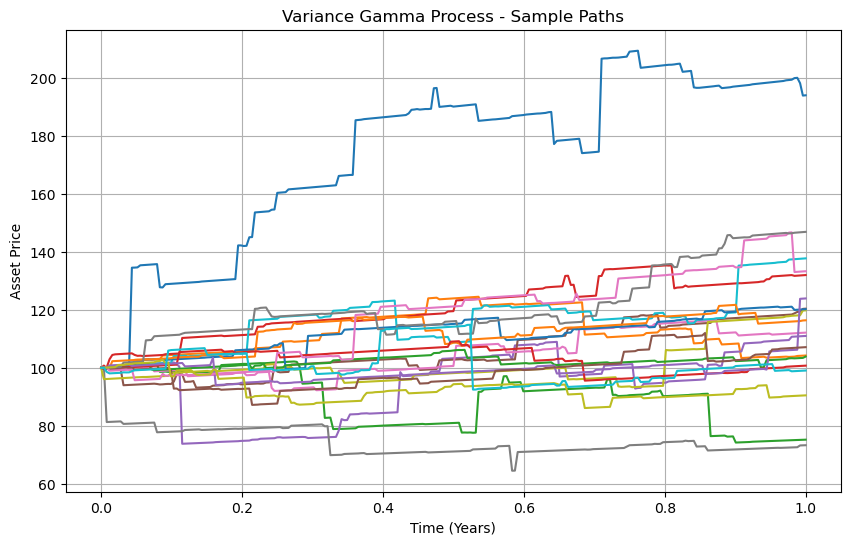

In [65]:
# Simulation parameters
T = 1.0
n_steps = 252
n_paths = 20

# Create model and simulate
vg_model = VarianceGammaModel(S0=100, r=0.05, sigma=0.2, nu=0.2, theta=-0.1)
paths = vg_model.simulate_paths(T, n_steps, n_paths)
time_grid = np.linspace(0, T, n_steps + 1)

plt.figure(figsize=(10, 6))
plt.plot(time_grid, paths)
plt.title("Variance Gamma Process - Sample Paths")
plt.xlabel("Time (Years)")
plt.ylabel("Asset Price")
plt.grid(True)
plt.show()

## 5. Distribution Comparison

Comparing the log-return distribution of VG vs Geometric Brownian Motion (Black-Scholes).

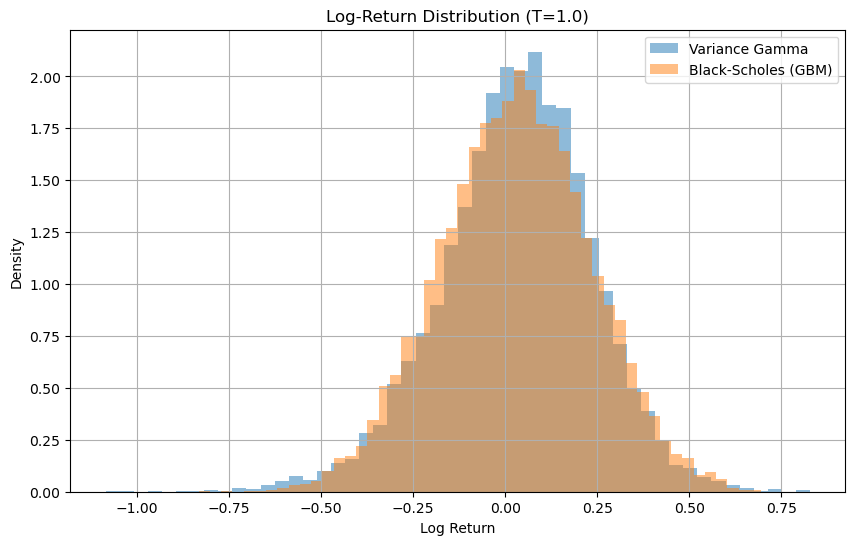

In [66]:
T = 1.0
n_paths = 10000

# VG Simulation
vg_model = VarianceGammaModel(S0=100, r=0.05, sigma=0.2, nu=0.2, theta=-0.1)
st_vg = vg_model.simulate_terminal_values(T, n_paths)
log_returns_vg = np.log(st_vg / 100)

# GBM Simulation (BS)
# GBM: ln(S_T/S_0) ~ N((r - sigma^2/2)T, sigma^2 T)
# We use the equivalent volatility sigma_bs
sigma_bs = np.sqrt(0.2**2 + 0.2 * (-0.1) ** 2)
mu_bs = 0.05 - 0.5 * sigma_bs**2
log_returns_bs = np.random.normal(mu_bs * T, sigma_bs * np.sqrt(T), n_paths)

plt.figure(figsize=(10, 6))
plt.hist(log_returns_vg, bins=50, alpha=0.5, density=True, label="Variance Gamma")
plt.hist(log_returns_bs, bins=50, alpha=0.5, density=True, label="Black-Scholes (GBM)")
plt.title(f"Log-Return Distribution (T={T})")
plt.xlabel("Log Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

## 6. Implied Volatility Smile

Calculating and plotting the implied volatility surface (smile) with respect to strike prices.
We calculate VG prices for a range of strikes and find the Black-Scholes implied volatility for each price.

Calculating Implied Volatility Smile...


<>:49: SyntaxWarning: invalid escape sequence '\s'
<>:49: SyntaxWarning: invalid escape sequence '\s'
/var/folders/gq/wbwfcz5j7z59ktdhq7_wvhjh0000gn/T/ipykernel_64094/3619850796.py:49: SyntaxWarning: invalid escape sequence '\s'
  f"Variance Gamma Implied Volatility Smile\n(T={T}, $\sigma$={sigma}, $\\nu$={nu}, $\\theta$={theta})"


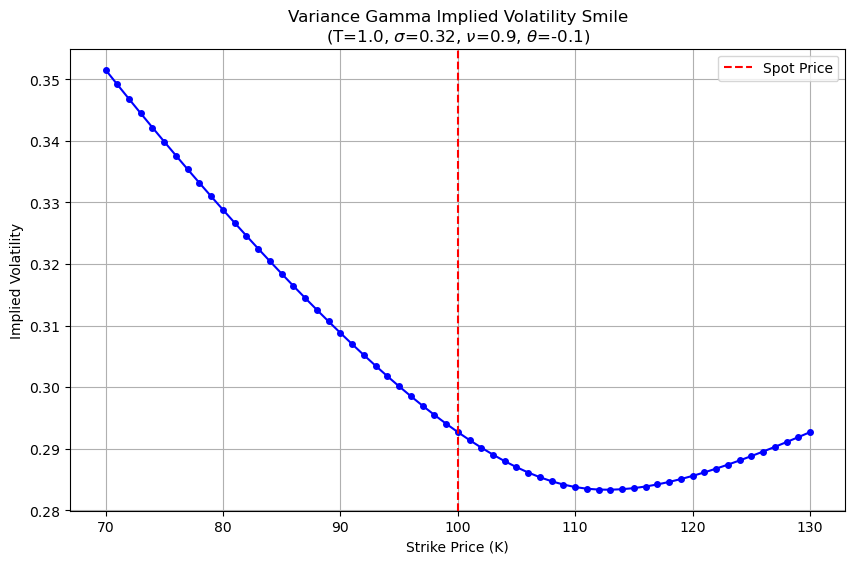

In [67]:
def implied_volatility(price, S, K, T, r, option_type="call"):
    """
    Calculates Black-Scholes implied volatility from an option price.
    """

    def objective_function(sigma_imp):
        if sigma_imp <= 0:
            return -price
        if option_type == "call":
            return bs_call_price(S, K, T, r, sigma_imp) - price
        else:
            # Not implemented for put here, but could be easily added
            return np.nan

    try:
        # Use Brent's method to find the root (implied vol)
        # Range for volatility: 0.001 to 5.0 (500%)
        implied_vol = brentq(objective_function, 1e-5, 5.0)
        return implied_vol
    except ValueError:
        return np.nan


# Parameters for Smile
S0 = 100
r = 0.05
T = 1.0
sigma = 0.32
nu = 0.9
theta = -0.1  # Negative skewness

# Strike range
strikes = np.linspace(70, 130, 61)
implied_vols = []

print("Calculating Implied Volatility Smile...")
for K_i in strikes:
    # 1. Calculate VG Price
    vg_price = vg_call_price(S0, K_i, T, r, sigma, nu, theta)

    # 2. Calculate Implied Volatility
    iv = implied_volatility(vg_price, S0, K_i, T, r)
    implied_vols.append(iv)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(strikes, implied_vols, "b-o", markersize=4)
plt.title(
    f"Variance Gamma Implied Volatility Smile\n(T={T}, $\sigma$={sigma}, $\\nu$={nu}, $\\theta$={theta})"
)
plt.xlabel("Strike Price (K)")
plt.ylabel("Implied Volatility")
plt.axvline(x=S0, color="r", linestyle="--", label="Spot Price")
plt.legend()
plt.grid(True)
plt.show()